In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())

[CudaDevice(id=0)]


In [107]:
@dataclasses.dataclass(frozen=True)
class VlasovPoissonSolverParticles(VlasovPoissonSolver):
    f_eq_: Callable[[Array, Array], Array]


    # Generate particles for equilibrium two-stream case
    def generate_particles_equilibrium_two_stream(self):
        # Extract the mesh parameters and the function
        mesh = self.mesh
        f_eq_ = self.f_eq_

        # Define a JIT-compatible helper function
        @jax.jit
        def generate_particles_jit():
            # Vectorized over x and v grid points
            x_vals = (jnp.arange(mesh.nx) + 0.5) * mesh.dx
            v_vals = jnp.linspace(-mesh.period_v + 0.5 * mesh.dv,
                                  mesh.period_v - 0.5 * mesh.dv, mesh.nv)

            # Compute weights for each (x, v)
            def compute_weights(x, v):
                weights = f_eq_(x, v) * mesh.dx * mesh.dv
                weight_sum = jnp.sum(weights)
                return jax.lax.cond(weight_sum != 0,
                                    lambda: weights * (mesh.dx / weight_sum),
                                    lambda: weights)

            # Use vmap for vectorized computation over x and v
            normalized_weights = jax.vmap(lambda x: jax.vmap(lambda v: compute_weights(x, v))(v_vals))(x_vals)

            # Flattening x, v, and normalized_weights to a flat list of tuples (x, v, weight)
            x_flat = jnp.repeat(x_vals, mesh.nv)
            v_flat = jnp.tile(v_vals, mesh.nx)
            w_flat = normalized_weights.flatten()

            # Create the flat particle array
            particles = jnp.stack([x_flat, v_flat, w_flat], axis=-1)

            return particles

        # Call the JIT-ed function
        return generate_particles_jit()

    # Generate particles for non-equilibrium two-stream case
    def generate_particles_two_stream(self, f, epsilon, beta):
        # Extract mesh parameters
        mesh = self.mesh

        # Define a JIT-compatible helper function
        @jax.jit
        def generate_particles_jit():
            # Vectorized over x and v grid points
            x_vals = (jnp.arange(mesh.nx) + 0.5) * mesh.dx
            v_vals = jnp.linspace(-mesh.period_v + 0.5 * mesh.dv,
                                  mesh.period_v - 0.5 * mesh.dv, mesh.nv)

            # Compute weights for each x
            def compute_weights(x,v):
                normalization_factor = (1 + epsilon * jnp.cos(beta * x)) * mesh.dx
                weights = f(x, v) * mesh.dx * mesh.dv
                weight_sum = jnp.sum(weights)
                return jax.lax.cond(weight_sum != 0,
                                    lambda: weights * (normalization_factor / weight_sum),
                                    lambda: weights)

            # Use vmap for vectorized computation over x
            normalized_weights = jax.vmap(lambda x: jax.vmap(lambda v: compute_weights(x, v))(v_vals))(x_vals)

            # Flatten x, v, and normalized_weights to a flat list of tuples (x, v, weight)
            x_flat = jnp.repeat(x_vals, mesh.nv)
            v_flat = jnp.tile(v_vals, mesh.nx)
            w_flat = normalized_weights.flatten()

            # Create the flat particle array
            particles = jnp.stack([x_flat, v_flat, w_flat], axis=-1)

            return particles

        # Call the JIT-ed function
        return generate_particles_jit()

        

    # Compute the density rho(x) from particles
    def compute_rho(self, particles):

        mesh = self.mesh

        @jax.jit
        def compute_density_jit():
            x_vals = (jnp.arange(mesh.nx) + 0.5) * mesh.dx
    
            # Accumulate weights in corresponding x cells
            def accumulate_density(rho_x, particle):
                x, _, weight = particle
                cell_index = jnp.floor_divide(x, mesh.dx).astype(int)
                rho_x = rho_x.at[cell_index].add(weight)
                return rho_x
        
            # Initialize rho(x)
            rho_x = jnp.zeros(mesh.nx)
        
            # Vectorized reduction over particles
            rho_x = jax.lax.fori_loop(0, particles.shape[0], 
                                      lambda i, rho: accumulate_density(rho, particles[i]), 
                                      rho_x)
        
            return x_vals, rho_x / mesh.dx

        # Call the JIT-ed function
        return compute_density_jit()

    def compute_E_from_rho(self, rho: Array) -> Array:
        rho_hat = jnp.fft.fft(rho)
        E_hat = jnp.zeros_like(rho_hat)
        inv_multiplier = -1.0 / (1j * 2 * jnp.pi * jnp.fft.fftfreq(self.mesh.nx, d=self.mesh.period_x / self.mesh.nx)[1:])
        E_hat = E_hat.at[1:].set(inv_multiplier * rho_hat[1:])
        return jnp.real(jnp.fft.ifft(E_hat))


    import numpy as np

    # Verlet integration method for N^2 particles in 1D, with periodic boundary conditions
    def verlet_integration_particles(self, particles, num_steps):
        """
        Simulate the movement of particles using the Verlet integration scheme.
    
        Parameters:
        particles (array): Array of particles with shape (N, 3), where each particle is (x, v, weight)
        num_steps (int): Number of time steps
        
        Returns:
        particles: Updated array of particles after integration
        """
        mesh = self.mesh
        dt = self.dt
        positions = particles[:, 0]
        velocities = particles[:, 1]
    
        # Compute initial charge density and electric field
        x_centers, rho_x = self.compute_rho(particles)
        E_x = self.compute_E_from_rho(rho_x)
    
        # Interpolate the electric field at particle positions
        indices = jnp.floor(positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
        E_at_positions = E_x[indices]
    
        # Define the function to execute at each time step using jax.lax.fori_loop
        @jax.jit
        def step_fn(step, carry):
            positions, velocities, E_at_positions = carry
    
            # Update positions using Verlet's method
            new_positions = positions + velocities * dt + 0.5 * dt**2 * E_at_positions
    
            # Apply periodic boundary conditions on positions
            new_positions = new_positions % mesh.period_x
    
            # Compute the charge density and electric field at new positions
            updated_particles = jnp.column_stack((new_positions, velocities, particles[:, 2]))
            _, rho_x = self.compute_rho(updated_particles)
            E_x = self.compute_E_from_rho(rho_x)
    
            # Interpolate the electric field at new positions
            new_indices = jnp.floor(new_positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
            E_at_positions_new = E_x[new_indices]
    
            # Update velocities using the average electric field
            new_velocities = velocities + 0.5 * dt * (E_at_positions + E_at_positions_new)
    
            # Apply velocity clamping: restrict velocities to the range [-period_v, period_v]
            new_velocities = jnp.clip(new_velocities, -mesh.period_v, mesh.period_v)
    
            return new_positions, new_velocities, E_at_positions_new
    
        # Use jax.lax.fori_loop for looped operations to preserve JIT compatibility
        final_positions, final_velocities, _ = jax.lax.fori_loop(
            0, num_steps, step_fn, (positions, velocities, E_at_positions)
        )
    
        # Update the particles array with the final positions and velocities
        updated_particles = jnp.column_stack((final_positions, final_velocities, particles[:, 2]))
    
        return updated_particles


    # Verlet integration method for N^2 particles in 1D, with periodic boundary conditions
    def verlet_integration_particles_with_H(self, particles, num_steps, H):
        """
        Simulate the movement of particles using the Verlet integration scheme.
    
        Parameters:
        particles (array): Array of particles with shape (N, 3), where each particle is (x, v, weight)
        num_steps (int): Number of time steps
        
        Returns:
        particles: Updated array of particles after integration
        """
        mesh = self.mesh
        dt = self.dt
        positions = particles[:, 0]
        velocities = particles[:, 1]
    
        # Compute initial charge density and electric field
        x_centers, rho_x = self.compute_rho(particles)
        E_x = self.compute_E_from_rho(rho_x)
    
        # Interpolate the electric field at particle positions
        indices = jnp.floor(positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
        E_at_positions = E_x[indices]
        H_at_positions = H(x_centers)[indices]
    
        # Define the function to execute at each time step using jax.lax.fori_loop
        @jax.jit
        def step_fn(step, carry):
            positions, velocities, E_at_positions, H_at_positions = carry
    
            # Update positions using Verlet's method
            new_positions = positions + velocities * dt + 0.5 * dt**2 * (E_at_positions + H_at_positions)
    
            # Apply periodic boundary conditions on positions
            new_positions = new_positions % mesh.period_x
    
            # Compute the charge density and electric field at new positions
            updated_particles = jnp.column_stack((new_positions, velocities, particles[:, 2]))
            x_centers, rho_x = self.compute_rho(updated_particles)
            E_x = self.compute_E_from_rho(rho_x)
    
            # Interpolate the electric field at new positions
            new_indices = jnp.floor(new_positions / (mesh.period_x / mesh.nx)).astype(int) % mesh.nx
            E_at_positions_new = E_x[new_indices]
            H_at_positions_new = H(x_centers)[new_indices]
    
            # Update velocities using the average electric field
            new_velocities = velocities + 0.5 * dt * (E_at_positions + E_at_positions_new + H_at_positions + H_at_positions_new)
    
            # Apply velocity clamping: restrict velocities to the range [-period_v, period_v]
            new_velocities = jnp.clip(new_velocities, -mesh.period_v, mesh.period_v)
    
            return new_positions, new_velocities, E_at_positions_new, H_at_positions_new
    
        # Use jax.lax.fori_loop for looped operations to preserve JIT compatibility
        final_positions, final_velocities, _ , _ = jax.lax.fori_loop(
            0, num_steps, step_fn, (positions, velocities, E_at_positions, H_at_positions)
        )
    
        # Update the particles array with the final positions and velocities
        updated_particles = jnp.column_stack((final_positions, final_velocities, particles[:, 2]))
    
        return updated_particles



In [108]:

def two_stream_distribution(x, v, v_bar, epsilon, beta):
    return (1 / (2 * jnp.sqrt(2 * jnp.pi))) * (
        jnp.exp(-(v - v_bar)**2 / 2) + jnp.exp(-(v + v_bar)**2 / 2)
        ) * (1 + epsilon * jnp.cos(beta * x))

#@jax.jit
#def two_stream_distribution(x, v, mu_1, mu_2, alpha):
#    return (alpha * jnp.exp(-0.5 * (x - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (v - mu2)**2)) / jnp.sqrt(2 * jnp.pi)


In [123]:
# Problem setup
nx = 512
nv = 512
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
num_steps = int(t_final/dt)
L = 10 * jnp.pi
LV = 6.0

In [124]:
mesh = make_mesh(L, LV, nx, nv)

alpha = 0.5
mu1 = 2.4
mu2 = -2.4
epsilon = 0.005
k_0 = 0.2
f_eq_ = lambda x, v: two_stream_distribution(x, v, mu1, 0, k_0)
#f_eq = (alpha * jnp.exp(-0.5 * (mesh.V - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (mesh.V - mu2)**2)) / jnp.sqrt(2 * jnp.pi)
f_eq = f_eq_(mesh.X, mesh.V)
#f_iv_ = lambda x, v: (1.0 + epsilon * jnp.cos(k_0 * x)) * f_eq_(x,v)
f_iv_ = lambda x, v: two_stream_distribution(x, v, mu1, epsilon, k_0)
#f_iv = (1.0 + epsilon * jnp.cos(k_0 * mesh.X)) * f_eq

In [125]:
solver = VlasovPoissonSolverParticles(mesh=mesh, dt=dt, f_eq=jnp.array(f_eq), f_eq_=f_eq_)

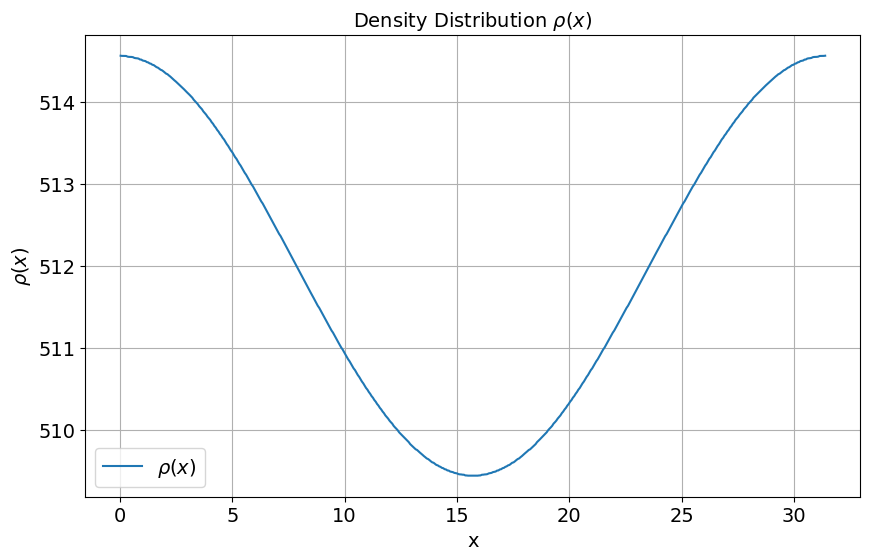

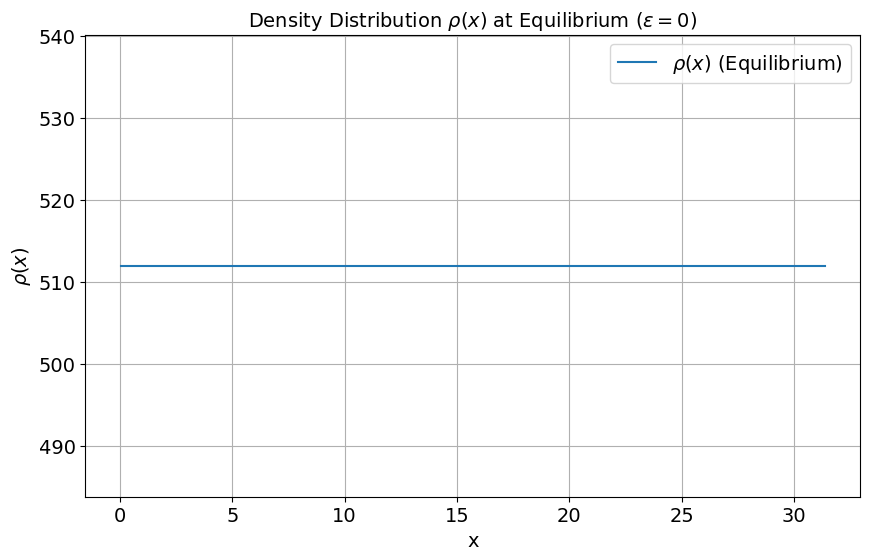

In [126]:
# Generate particles using the two-stream distribution
particles = solver.generate_particles_two_stream(f_iv_, epsilon, k_0)

# Generate particles for the equilibrium distribution
equilibrium_particles = solver.generate_particles_equilibrium_two_stream()


# Compute the density rho(x)
x_centers, rho_x = solver.compute_rho(particles)

# Plot the density rho(x)
plt.figure(figsize=(10, 6))
plt.plot(x_centers, rho_x, label=r'$\rho(x)$')
plt.title(r'Density Distribution $\rho(x)$')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

# Compute the density rho(x) for the equilibrium state
x_centers_eq, rho_x_eq = solver.compute_rho(equilibrium_particles)

# Plot the density rho(x) for the equilibrium state
plt.figure(figsize=(10, 6))
plt.plot(x_centers_eq, rho_x_eq, label=r'$\rho(x)$ (Equilibrium)')
plt.title(r'Density Distribution $\rho(x)$ at Equilibrium ($\epsilon=0$)')
plt.xlabel('x')
plt.ylabel(r'$\rho(x)$')
plt.grid(True)
plt.legend()
plt.show()

In [89]:
a_k = 0.05
H = lambda x: a_k * jnp.cos(k_0 * x)  # External field function H(x)


update_particles = solver.verlet_integration_particles_with_H(particles, num_steps, H)

2024-10-24 02:29:54.609682: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %slice.38 = f32[262144,1]{1,0} slice(f32[262144,3]{1,0} %constant.295), slice={[0:262144], [2:3]}, metadata={op_name="jit(scan)/jit(main)/while/body/jit(step_fn)/slice" source_file="/tmp/ipykernel_1201370/569844878.py" source_line=225}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-10-24 02:29:54.884965: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.275402109s
Constant folding an instruction is taking > 1s:

  %slice.38 = f32[262144,1]{1,0} slice(f32[262144,3]{1,0} %const

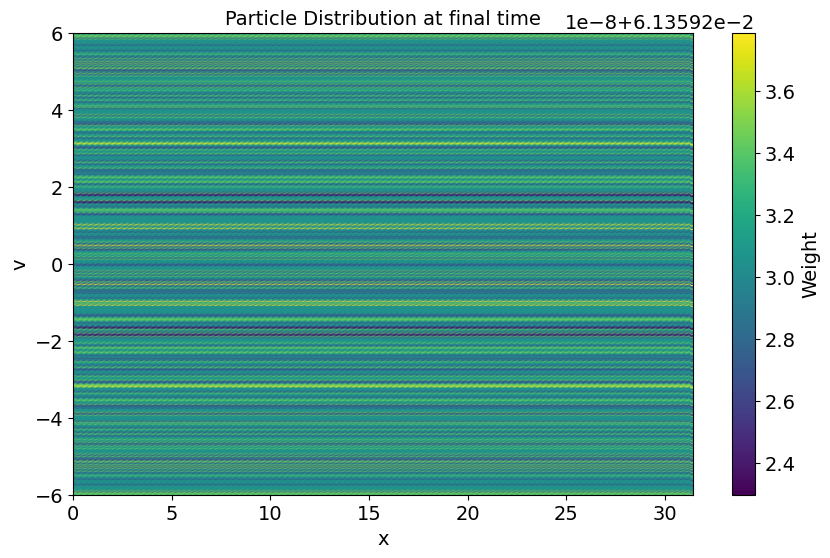

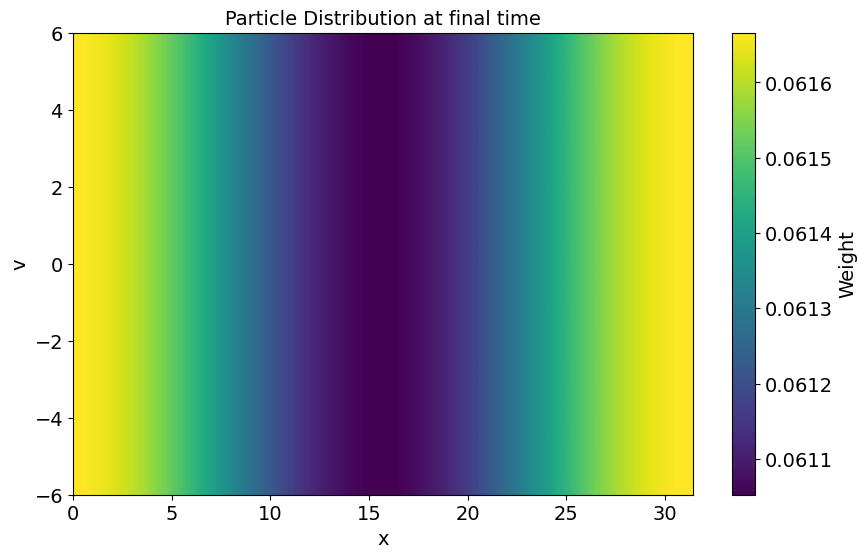

In [127]:
# Function to plot particles with color representing their weights
def plot_particles(particles, mesh):
    """
    Plot the particles with color representing their weights at a specific time step.

    Parameters:
    particles (list): List of particles (x, v, weight)
    v_max (float): Maximum velocity
    L (float): Length of the domain for x
    step (int): The current time step
    """
    x_vals = particles[:,0]
    v_vals = particles[:,1]
    weights = particles[:,2]
    #weights_norm = weights/jnp.linalg.norm(weights)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x_vals, v_vals, c=weights, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Weight')
    plt.xlim(0, mesh.period_x)
    plt.ylim(-mesh.period_v, mesh.period_v)
    plt.title(f'Particle Distribution at final time')
    plt.xlabel('x')
    plt.ylabel('v')
    plt.show()



plot_particles(equilibrium_particles, mesh)
plot_particles(particles, mesh)

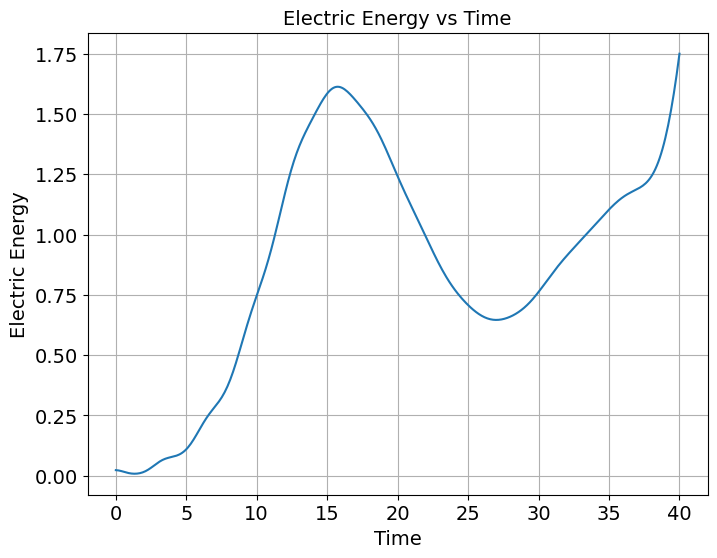

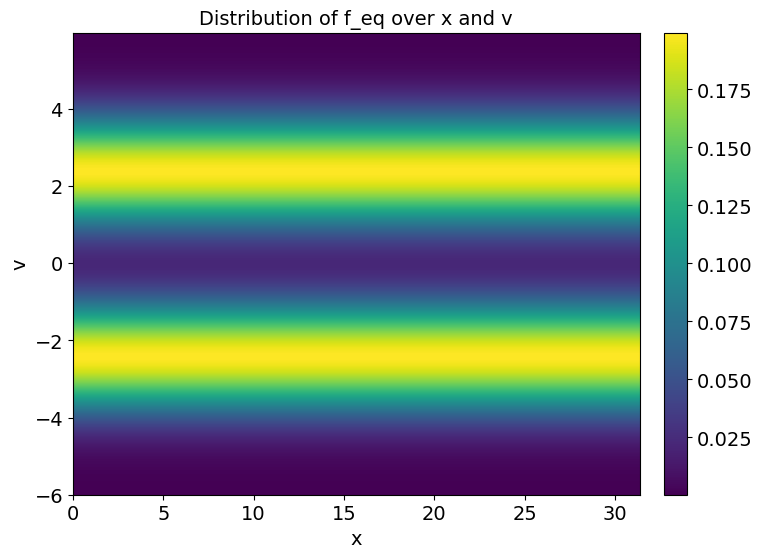

(512, 512)


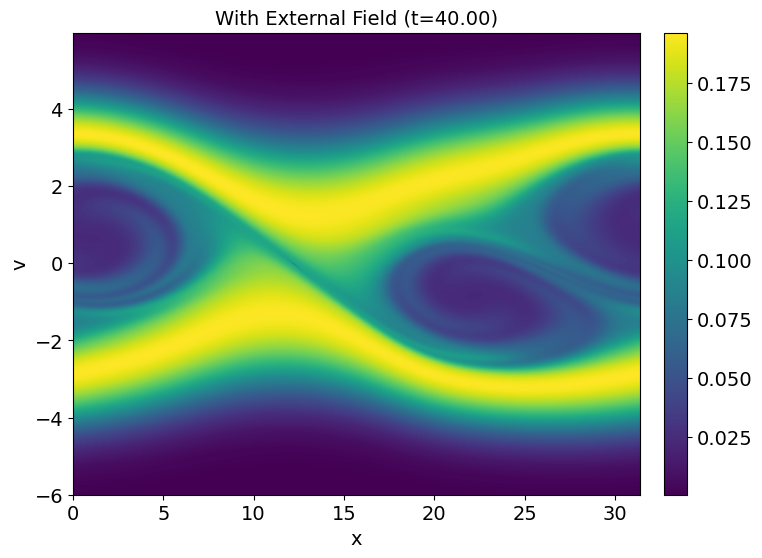

In [3]:
mesh = make_mesh(L, LV, nx, nv)



alpha = 0.5
mu1 = 2.4
mu2 = -2.4
f_eq_ = lambda x, v: two_stream_distribution(x, v, mu_1, mu_2, alpha)
#f_eq = (alpha * jnp.exp(-0.5 * (mesh.V - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (mesh.V - mu2)**2)) / jnp.sqrt(2 * jnp.pi)
f_eq = f_eq_(mesh.X, mesh.V)
epsilon = 0.001
k_0 = 0.2
f_iv_ = lambda x, v: (1.0 + epsilon * jnp.cos(k_0 * x)) * f_eq(x,v)
f_iv = (1.0 + epsilon * jnp.cos(k_0 * mesh.X)) * f_eq

# External field parameters (coefficients for the cosine terms)
a_k = [0.004, 0.05, -0.02, 0.0, 0.0]

# Function to compute the external field H (not time-dependent)
def compute_external_field(xs, a_k):
    H = np.zeros(len(xs))  # Initialize H as a 1D array (space)
    for k in range(1, 6):  # Iterate over k from 1 to 5
        H += a_k[k - 1] * np.cos(k * xs / L * 2 * np.pi)  # Compute H for each k and sum
    return H

# Compute the external field
H = jnp.array(compute_external_field(mesh.xs, a_k))

num_steps = int(t_final / dt)

# Function to plot the distribution of f_eq over x and v
def plot_feq_distribution(ax, f_eq, title):
    im = ax.imshow(f_eq.transpose(), extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='viridis')  # 'auto' aspect ratio
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

# Modify the plot_distribution function to handle 2D data
def plot_distribution(ax, data, title, time):
    im = ax.imshow(data.T, extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='viridis')  # Transpose data
    ax.set_title(f'{title} (t={time:.2f})')
    ax.set_xlabel('x')
    ax.set_ylabel('v')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=jnp.array(f_eq))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Fix the unpacking here
f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final=t_final)

# Create a figure with a single plot for electric energy
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final / dt))

plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

print(f_array.shape)  # This will help understand the dimensions of f_array


# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# f_array is already a 2D array, so pass it directly to the plot
plot_distribution(ax, f_array, 'With External Field', t_final)

# Display the plot
plt.show()

Initial cost J: 1.3280019760131836


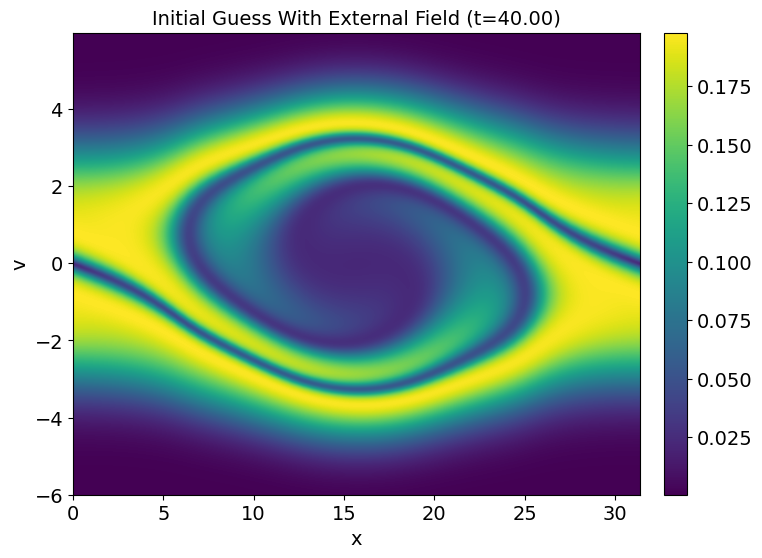

Iteration 0, Cost: 1.3280019760131836
Iteration 100, Cost: 0.8660446405410767
Iteration 200, Cost: 0.7653841972351074
Iteration 300, Cost: 0.700304388999939
Iteration 400, Cost: 0.6779905557632446
Iteration 500, Cost: 0.6655583381652832
Iteration 600, Cost: 0.6556302905082703
Iteration 700, Cost: 0.6468279361724854
Iteration 800, Cost: 0.6336515545845032
Iteration 900, Cost: 0.6180581450462341


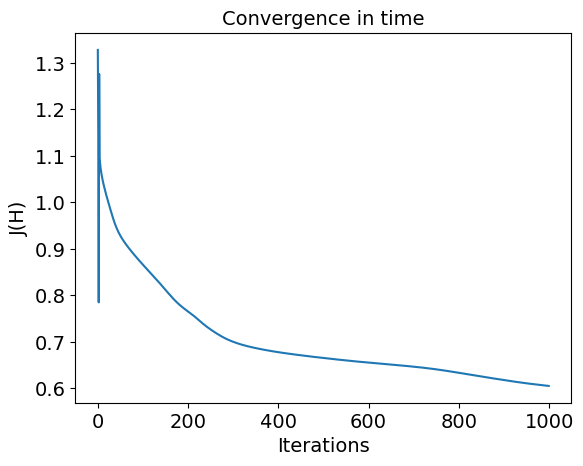

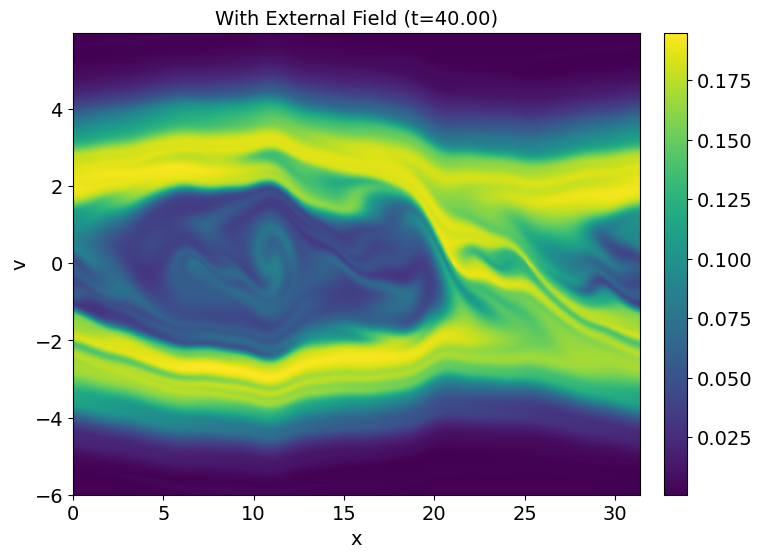

In [5]:
# Optimization through auto-differentiation with fixed basis.

# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
 -0.0, 0])

# Function to compute the external field H based on coefficients a_k
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)
    for k in range(1, 15):  # k from 1 to 11
        H += a_k[k-1] * jnp.cos(k * xs / L * 2 * jnp.pi)
    return H

# Define the cost function using JAX
def cost_function(a_k):
    H = compute_external_field(mesh.xs, a_k)
    # JIT-compiled forward solver
    solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    f_final = f_array
    cost = J(f_final, f_eq, solver)
    return cost

# Adjust the J function to use f_final
def J(f_final, f_eq, solver):
    return jnp.sum((f_final - f_eq) ** 2) * solver.mesh.dx * solver.mesh.dv

# Compute the gradient using JAX's automatic differentiation
cost_and_grad_function = jax.jit(jax.value_and_grad(cost_function))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Plot the final distribution before optimization using the initial guess of H
H_initial = compute_external_field(mesh.xs, a_k)
f_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)

f_final_initial = f_array_initial

# Print J (cost function value) for the initial guess
J_initial = J(f_final_initial, f_eq, solver)
print(f'Initial cost J: {J_initial}')

# Create a figure for the initial plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution at the final time with the initial guess
plot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)

# Display the initial plot
plt.show()

# Now proceed with the optimization loop
maxIter = 1000  # Number of optimization iterations
hist_J = []

for i in range(maxIter):
    # Compute cost and gradient
    cost, grad = cost_and_grad_function(a_k)
    hist_J.append(cost)
    if i%100 == 0:
        print(f'Iteration {i}, Cost: {cost}')
        #print(f'Iteration {i}, a_k: {a_k}')  # Print the current value of a_k

    # Update a_k using a simple gradient descent step or line search
    # For simplicity, let's use gradient descent with a fixed learning rate
    learning_rate = 0.001
    a_k = a_k - learning_rate * grad
    
    # After each iteration, plot the distribution
    H = compute_external_field(mesh.xs, a_k)
    ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
    f_final = ff_array

# Plot the value of the cost function during the iteration process
plt.plot(hist_J)
plt.title('Convergence in time')
plt.ylabel('J(H)')
plt.xlabel('Iterations')
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()

Initial cost J: 0.2479017674922943


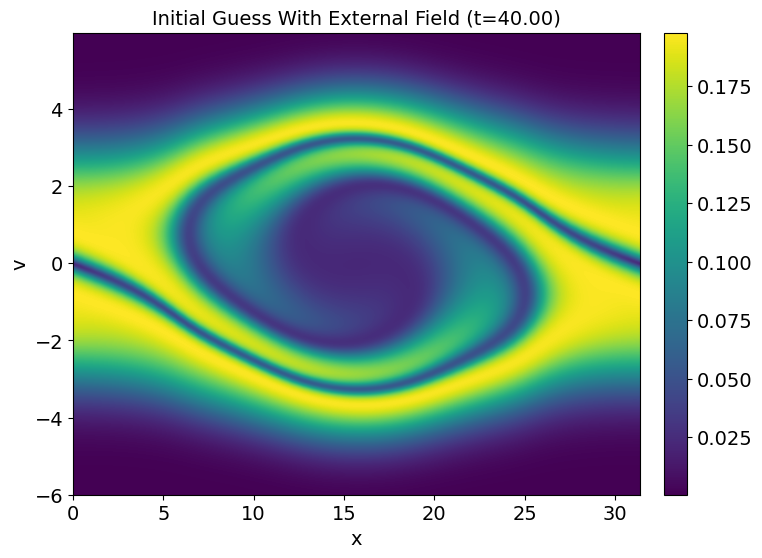

Iteration 0, Cost: 0.2479017674922943
Iteration 100, Cost: 0.15336474776268005
Iteration 200, Cost: 0.12577034533023834
Iteration 300, Cost: 0.1094401404261589
Iteration 400, Cost: 0.10452733188867569
Iteration 500, Cost: 0.10164417326450348
Iteration 600, Cost: 0.09963887184858322
Iteration 700, Cost: 0.09811462461948395
Iteration 800, Cost: 0.09688179194927216
Iteration 900, Cost: 0.09580168128013611


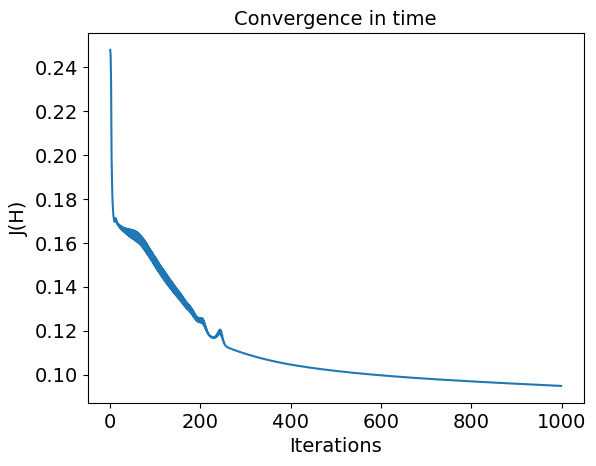

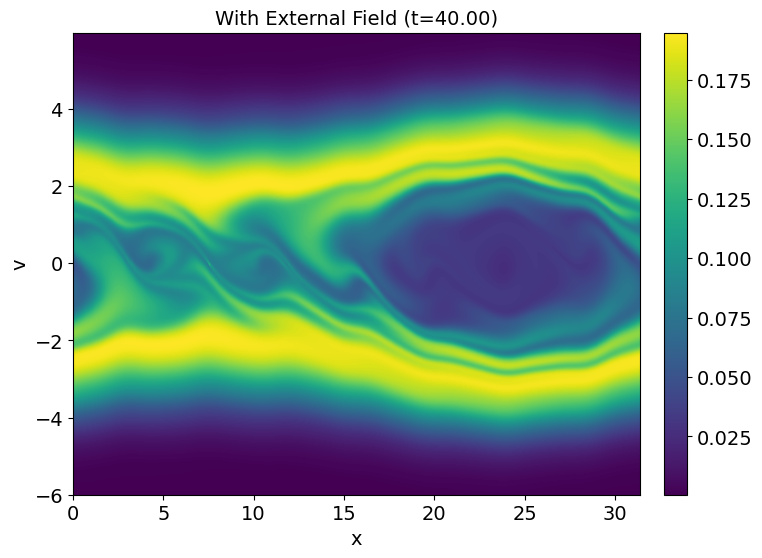

In [6]:
# Optimization through auto-differentiation with fixed basis.

# External field parameters (coefficients for the cosine terms)
# Initial guess for the coefficients
a_k = jnp.array([0.0, 0.0, -0.0, 0.0, 0.0,  -0.0,
  0.0,    0.0,  -0.0, -0.0, -0.0,  0.0,
 -0.0, 0])

# Function to compute the external field H based on coefficients a_k
def compute_external_field(xs, a_k):
    H = jnp.zeros_like(xs)
    for k in range(1, 15):  # k from 1 to 11
        H += a_k[k-1] * jnp.cos(k * xs / L * 2 * jnp.pi)
    return H

def kl_divergence(f_final, f_eq, solver, eps=1e-8):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = f_eq / (jnp.sum(f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(f_final * jnp.log(f_final / (f_eq + eps) + eps)) * solver.mesh.dx * solver.mesh.dv
    return kl_div

def cost_function_kl(a_k):
    H = compute_external_field(mesh.xs, a_k)
    # JIT-compiled forward solver
    solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    f_final = f_array
    cost = kl_divergence(f_final, f_eq, solver)
    return cost


# Compute the gradient using JAX's automatic differentiation
cost_and_grad_function = jax.jit(jax.value_and_grad(cost_function_kl))

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Plot the final distribution before optimization using the initial guess of H
H_initial = compute_external_field(mesh.xs, a_k)
f_array_initial, E_array_initial, ee_array_initial = solver_jit(jnp.array(f_iv), jnp.array(H_initial), t_final)

f_final_initial = f_array_initial

# Print J (cost function value) for the initial guess
J_initial = kl_divergence(f_final_initial, f_eq, solver)
print(f'Initial cost J: {J_initial}')

# Create a figure for the initial plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution at the final time with the initial guess
plot_distribution(ax, f_array_initial, 'Initial Guess With External Field', t_final)

# Display the initial plot
plt.show()

# Now proceed with the optimization loop
maxIter = 1000  # Number of optimization iterations
hist_J = []

for i in range(maxIter):
    # Compute cost and gradient
    cost, grad = cost_and_grad_function(a_k)
    hist_J.append(cost)
    if i%100 == 0:
        print(f'Iteration {i}, Cost: {cost}')
        #print(f'Iteration {i}, a_k: {a_k}')  # Print the current value of a_k
    
    # Update a_k using a simple gradient descent step or line search
    # For simplicity, let's use gradient descent with a fixed learning rate
    learning_rate = 0.001
    a_k = a_k - learning_rate * grad
    
    # After each iteration, plot the distribution
    H = compute_external_field(mesh.xs, a_k)
    ff_array, E_array, ee_array = solver.run_forward_jax_scan(jnp.array(f_iv), jnp.array(H), t_final)
    
    f_final = ff_array

# Plot the value of the cost function during the iteration process
plt.plot(hist_J)
plt.title('Convergence in time')
plt.ylabel('J(H)')
plt.xlabel('Iterations')
plt.show()

# Plot the distribution at the final time for the current iteration
fig, ax = plt.subplots(figsize=(8, 6))
plot_distribution(ax, f_final, 'With External Field', t_final)
plt.show()